In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle.json': b'{"username":"wangxbzb","key":"e4718fa519370159f1f421468f9c604b"}'}

In [3]:
!pip install torch
!pip install torchvision
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

In [4]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p data

test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile
with zipfile.ZipFile('data/train.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
with zipfile.ZipFile('data/test.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [0]:
import os
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


LABEL_IX = {
    'cat': 0,
    'dog': 1,
}

def make_dataset(root):
    samples = []
    filenames = os.listdir(root)
    filenames.sort(key=lambda s: int(''.join(ch for ch in s if ch.isdigit())))
    for filename in filenames:
        path = os.path.join(root, filename)
        label = filename.split('.')[0]
        try:
          samples.append([path, LABEL_IX[label]])
        except:
          samples.append([path, 0.5])
    return samples

def load_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

      
def load_id_image(path):
    return path.split('.')[0], load_image(path)
  
  
class ImageFolder(Dataset):
    def __init__(self, root, transform, target_transform=None, loader=load_image):
        samples = make_dataset(root)
        if not samples:
            raise(RuntimeError("Found 0 files in subfolders of: " + root + "\n"))

        self.root = root
        self.loader = loader
        self.samples = samples
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.samples)

batch_size = 16
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


train_dataset = ImageFolder('data/train',
                            transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize,
                            ]))



test_dataset = ImageFolder('data/test',
                           transforms.Compose([
                               transforms.RandomResizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ]))

num_train_samples = int(len(train_dataset) * 0.95)
num_valid_samples = len(train_dataset) - num_train_samples

train_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset, [num_train_samples, num_valid_samples])

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

valid_dl = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True)

test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size*2,
)

In [7]:
import re

import torch
import torch.nn as nn
import torchvision.models as models


class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        self.resnet101.fc = nn.Sequential(nn.Linear(2048, 1))

    def forward(self, x):
        return self.resnet101(x)

model = MyModel()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

42502209


In [0]:
def train(model, criterion, optimizers, train_dl, valid_dl, num_epochs):
    device = 'cuda'
    total_step = len(train_dl)
    model = model.to(device)
    for epoch in range(num_epochs):
        for step, (images, labels) in enumerate(train_dl):
            batch_size = len(labels)
            images = images.to(device)
            labels = labels.to(device).float()[:, None]

            logits = model(images)

            loss = criterion(
                logits,
                labels)
            
            optimizer = optimizers[step % len(optimizers)]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 50 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs,
                              step + 1, total_step, loss.item()))

                for images, labels in valid_dl:
                    images = images.to(device)
                    labels = labels.to(device).float()[:, None]
                    logits = model(images)
                    probs = torch.sigmoid(logits)
                    preds = (probs >= 0.5).float()
#                     _, preds = torch.max(outputs, 1)
                    acc = torch.mean((preds == labels).float())
                    loss = criterion(
                        logits,
                        labels)

                    print("Validation acc: {:.4f}, loss: {:.4f}".format(acc, loss))
                    break

In [9]:
optimizers = [torch.optim.Adam(model.resnet101.fc.parameters(), lr=1e-4),
              torch.optim.Adam(model.parameters(), lr=1e-5)]

train(model,
      nn.BCEWithLogitsLoss(),
      optimizers,
      train_dl,
      valid_dl,
      num_epochs=1)

Epoch [1/1], Step [1/1485], Loss: 0.7762
Validation acc: 0.5625, loss: 0.7102
Epoch [1/1], Step [51/1485], Loss: 0.4033
Validation acc: 0.9375, loss: 0.4337
Epoch [1/1], Step [101/1485], Loss: 0.1929
Validation acc: 1.0000, loss: 0.2947
Epoch [1/1], Step [151/1485], Loss: 0.2278
Validation acc: 1.0000, loss: 0.1529
Epoch [1/1], Step [201/1485], Loss: 0.0728
Validation acc: 1.0000, loss: 0.1266
Epoch [1/1], Step [251/1485], Loss: 0.3845
Validation acc: 1.0000, loss: 0.0508
Epoch [1/1], Step [301/1485], Loss: 0.1984
Validation acc: 1.0000, loss: 0.0520
Epoch [1/1], Step [351/1485], Loss: 0.0496
Validation acc: 1.0000, loss: 0.0887
Epoch [1/1], Step [401/1485], Loss: 0.1159
Validation acc: 0.9375, loss: 0.0792
Epoch [1/1], Step [451/1485], Loss: 0.1555
Validation acc: 0.7500, loss: 0.6505
Epoch [1/1], Step [501/1485], Loss: 0.0687
Validation acc: 1.0000, loss: 0.0451
Epoch [1/1], Step [551/1485], Loss: 0.2231
Validation acc: 0.9375, loss: 0.1262
Epoch [1/1], Step [601/1485], Loss: 0.0462


In [10]:
import pandas as pd

device = 'cuda'

results = []
for images, _ in test_dl:
  images = images.to(device)
  logits = model(images)
  probs = torch.sigmoid(logits)
  results += probs.detach().cpu().numpy().tolist()
  print(len(results))

32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496
6528
6560
6592
6624

In [11]:
import numpy as np

df = pd.DataFrame(results, columns=['label'])
df['id'] = df.index + 1
df = df[['id', 'label']]
df.to_csv('results.csv', index=None)
print(df.head())

   id     label
0   1  0.997553
1   2  0.999837
2   3  0.999540
3   4  0.989892
4   5  0.084353


probability of dog: 0.9990990161895752
(2048, 7, 7)


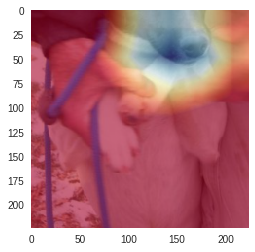

(2048, 7, 7)


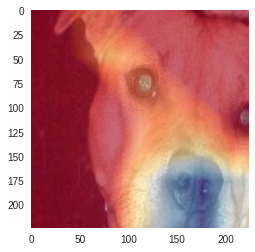

(2048, 7, 7)


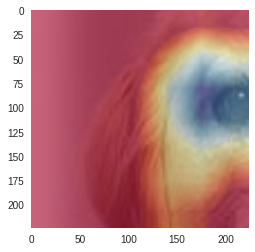

(2048, 7, 7)


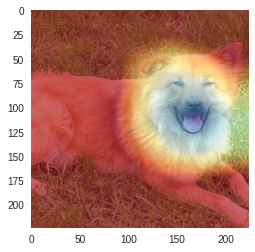

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model.resnet101.layer4.register_forward_hook(hook_feature)
params = list(model.resnet101.fc.parameters())
fc_weight = np.squeeze(params[0].cpu().detach().numpy())

for images, _ in test_dl:
    break
    
images = images.to(device)
logits = model(images)
probs = torch.sigmoid(logits)
print('probability of dog:', probs[0].item())


def calc_CAM(feature_conv, fc_weight):
  nc, h, w = feature_conv.shape
  fc_weight = fc_weight[None]
  print(feature_conv.shape)
  cam = fc_weight @ feature_conv.reshape((nc, h * w))
  cam = cam.reshape(h, w)
  cam -= cam.mean()
  cam /= (cam.max() - cam.min() + 1e-10)
  cam = cv2.resize(cam, (224, 224))
  cam = np.clip(cam, 0, 1)
  return cam

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
      
unnormalize = UnNormalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

for i in range(4):
    image = unnormalize(images[i]).permute([1, 2, 0]).cpu().numpy()
    cam = calc_CAM(features_blobs[0][i], fc_weight)

    plt.imshow(image)
    plt.imshow(cam, cmap=plt.cm.RdYlBu, alpha=0.6)

    plt.grid(False)
    plt.show()

In [13]:
!nvidia-smi

Mon Jan 14 17:12:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    69W / 149W |   9464MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
files.download('results.csv')